# SMN Rotation comparison

This notebook computes and compares the damage/DPS distribution for a SMN rotation from [Fryte's SMN planner spreadsheet.](https://docs.google.com/spreadsheets/d/1ndJhvqd1e0IlHFPz9iZK_9PjuOEtly6fLM-j6ldSPa4/edit#gid=0)

Additional files used:

* `smn-rotation.csv`: Rotation from Google sheet
* `fryte-results.csv`: Damage distribution values form Google sheet.

In [251]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ffxiv_stats.moments import Rotation
from ffxiv_stats.rate import Rate

# Stats to go from potency to D2
mAP = 29.533
trait = 1.3
det = 1.089

r = Rate(crit_amt=2514, dh_amt=1616)
p = r.get_p()
l_c = r.crit_dmg_multiplier()
l_d = 125

## Read in rotation from google sheet

Filter out non-damaging rows and do some checks that damage formulas are correctly recreated.

The `smn-rotation.csv` file is just the google sheet saved with some columns pruned and a few filters applied.

In [252]:
rotation_all = pd.read_csv('smn-rotation.csv')
rotation_all = rotation_all[rotation_all['D2'] > 0].reset_index()

# Checking that pet and smn potency formula matches spreadsheet, so they can be split up into separate hits/rows
rotation_all['d2_test'] = np.floor((rotation_all['potency'] + rotation_all['pet_pot']) * mAP * trait * det)

# Max error between all actions
print('Maximum D2 - d2_test difference:', (rotation_all['D2'] - rotation_all['d2_test']).abs().max())
# Mean absolute error, should be "small" due to flooring differences
print('Mean absolute error', (rotation_all['D2'] - rotation_all['d2_test']).abs().sum())

# Using own class to compute hit type probabilities because of floating point tomfoolerly
rotation_all.drop(['index', 'name', 'pNH', 'pCH', 'pDH', 'pCDH'], axis=1 , inplace=True)

rotation_all

Maximum D2 - d2_test difference: 1.0
Mean absolute error 57.0


,action,pet_action,time,D2,buffs_hack,actual_buffs,actual_buffs_2,potency,pet_pot,pet_base,base_pot,d2_test
0,R3,NaN,0.00,12960,1,1.00000,1.00,310,0.00,0,310,12961.0
1,Impulse,Wyrmwave,4.96,23341,1,1.03000,1.03,440,118.29,150,440,23342.0
2,Impulse,Wyrmwave,7.44,23341,1,1.10519,1.10,440,118.29,150,440,23342.0
3,Impulse,Wyrmwave,9.92,23341,1,1.10519,1.10,440,118.29,150,440,23342.0
4,ED,NaN,9.92,8361,1,1.10519,1.10,200,0.00,0,200,8361.0
...,...,...,...,...,...,...,...,...,...,...,...,...
250,MB,NaN,468.16,6271,1,1.00000,1.00,150,0.00,0,150,6271.0
251,TopRite,NaN,470.64,13797,1,1.00000,1.00,330,0.00,0,330,13797.0
252,MB,NaN,470.64,6271,1,1.00000,1.00,150,0.00,0,150,6271.0
253,R3,NaN,473.12,12960,1,1.00000,1.00,310,0.00,0,310,12961.0


### Transform rotation into a format that can be read by `ffxiv_stats`

Some rows have multiple actions from summons and pets. Each action needs to be split into a single row so they are correctly counted. 

An effective, merged_potency` field is created, which allows the same formula to be used on pet and normal potency actions

A unique action name is added based on which buffs are present.

The `actual_buffs_2` field is used because the spreadsheet trunacates to the 2nd decimal place, which adds some error compared to using full buffs. The `actual_buffs` field is with full precision. The full precision values are in the cells, but commented out.

In [256]:
# Pet actions
# Has a non-null pet_action and non-zero pet_pot
pet_rotation = rotation_all[(~rotation_all['pet_action'].isnull()) & (rotation_all['pet_pot'] > 0)].copy()
# Have pet and not pet potency as a single column
pet_rotation['merged_potency'] = pet_rotation['pet_pot']
# Also make a named uid based off action name and buffs
pet_rotation['uid'] = pet_rotation['pet_action'].str.lower().replace({' ':'_'})

# pet_rotation = pet_rotation[['uid', 'time', 'D2', 'actual_buffs', 'merged_potency']]
pet_rotation = pet_rotation[['uid', 'time', 'D2', 'actual_buffs', 'actual_buffs_2', 'merged_potency']]


# SMN actions
# Has a non-null name and a non-zero potency
smn_rotation = rotation_all[(~rotation_all['action'].isnull()) & (rotation_all['potency'] > 0)].copy()
# merged potency
smn_rotation['merged_potency'] = smn_rotation['potency']
# Same uid based off action
smn_rotation['uid'] = smn_rotation['action']
# smn_rotation = smn_rotation[['uid', 'time', 'D2', 'actual_buffs', 'merged_potency']]
smn_rotation = smn_rotation[['uid', 'time', 'D2', 'actual_buffs', 'actual_buffs_2', 'merged_potency']]

rotation_pre_count = pd.concat((pet_rotation, smn_rotation)).sort_values(by='time').reset_index().drop('index', axis=1)

rotation_pre_count['uid'] = np.select(
    [
        rotation_pre_count['actual_buffs'] == 1., 
        rotation_pre_count['actual_buffs'] == 1.03,
        rotation_pre_count['actual_buffs'] == 1.073,
        rotation_pre_count['actual_buffs'] == 1.10519,
        
    ], 
    [
        rotation_pre_count['uid'], 
        rotation_pre_count['uid'] + '-SL',
        rotation_pre_count['uid'] + '-pot',
        rotation_pre_count['uid'] + '-SL_pot'
    ], 
    default='Unknown'
)
# print(p)
rotation_pre_count['D2'] = np.floor(rotation_pre_count['merged_potency'] * mAP * det * trait)
rotation_pre_count

,uid,time,D2,actual_buffs,actual_buffs_2,merged_potency
0,R3,0.00,12961.0,1.00000,1.00,310.00
1,wyrmwave-SL,4.96,4945.0,1.03000,1.03,118.29
2,Impulse-SL,4.96,18396.0,1.03000,1.03,440.00
3,wyrmwave-SL_pot,7.44,4945.0,1.10519,1.10,118.29
4,Impulse-SL_pot,7.44,18396.0,1.10519,1.10,440.00
...,...,...,...,...,...,...
282,MB,468.16,6271.0,1.00000,1.00,150.00
283,TopRite,470.64,13797.0,1.00000,1.00,330.00
284,MB,470.64,6271.0,1.00000,1.00,150.00
285,R3,473.12,12961.0,1.00000,1.00,310.00


Just groupby count and add some other information like the critical hit modifier and the hit-type probability for each action (same for all of them since there are no hit type buffs).

Slipstream was manually counted and appended ad-hoc just because that was the easiest way to handle it.

In [249]:
column_map = {'uid': 'action-name', 'D2': 'd2', 'actual_buffs': 'buffs', 'time': 'n'}
column_map = {'uid': 'action-name', 'D2': 'd2', 'actual_buffs_2': 'buffs', 'time': 'n'}

# Group by count and do a little reindexing/renaming
# rotation = (
#     rotation_pre_count[['uid', 'D2', 'time', 'actual_buffs']].groupby(['uid', 'D2', 'actual_buffs'])
#                       .count().reset_index().rename(column_map, axis=1)
# )

rotation = (
    rotation_pre_count[['uid', 'D2', 'time', 'actual_buffs_2']].groupby(['uid', 'D2', 'actual_buffs_2'])
                      .count().reset_index().rename(column_map, axis=1)
)


# Add in CH modifier and probabilities 
rotation['l_c'] = l_c

# On a plane without internet which is why this is so stupidly coded
p_df = np.zeros((rotation.shape[0], 4))
for row in range(p_df.shape[0]):
    p_df[row] = p
rotation['p'] = p_df.tolist()

rotation['is-dot'] = False

buffs = rotation['buffs'].tolist()
buffs = [[b] for b in buffs]
rotation['buffs'] = buffs

# Assuming 6 ticks happen per application, only difference is presence of infusion or searing light
slip_dict = {
    'action-name': ['slipstream', 'slipstream-SL', 'slipstream-SL_pot'],
    'd2': [1262, 1262, 1262],
    'buffs': [[1], [1.03], [1.10]],
    'n': [4*6, 6, 3*6],
    'l_c': [l_c, l_c, l_c],
    'p': [p.tolist(), p.tolist(), p.tolist()],
    'is-dot': [True, True, True]
}

slip_df = pd.DataFrame(slip_dict)
rotation = pd.concat((rotation, slip_df)).reset_index()

rotation.sort_values('action-name')

,index,action-name,d2,buffs,n,l_c,p,is-dot
0,0,CC,17978.0,[1.0],7,1622.0,"[0.471744, 0.17625600000000002, 0.256256, 0.09...",False
1,1,CC-SL_pot,17978.0,[1.1],1,1622.0,"[0.471744, 0.17625600000000002, 0.256256, 0.09...",False
2,2,CS,17978.0,[1.0],7,1622.0,"[0.471744, 0.17625600000000002, 0.256256, 0.09...",False
3,3,CS-pot,17978.0,[1.07],1,1622.0,"[0.471744, 0.17625600000000002, 0.256256, 0.09...",False
4,4,DF-SL,20904.0,[1.03],1,1622.0,"[0.471744, 0.17625600000000002, 0.256256, 0.09...",False
5,5,DF-SL_pot,20904.0,[1.1],3,1622.0,"[0.471744, 0.17625600000000002, 0.256256, 0.09...",False
6,6,ED,8361.0,[1.0],4,1622.0,"[0.471744, 0.17625600000000002, 0.256256, 0.09...",False
7,7,ED-SL,8361.0,[1.03],1,1622.0,"[0.471744, 0.17625600000000002, 0.256256, 0.09...",False
8,8,ED-SL_pot,8361.0,[1.1],3,1622.0,"[0.471744, 0.17625600000000002, 0.256256, 0.09...",False
9,9,EmRite,9616.0,[1.0],16,1622.0,"[0.471744, 0.17625600000000002, 0.256256, 0.09...",False


# Now we can compute the damage distribution

The hard/tedious part is counting all the actions and which buffs are present. Once that's done, computing the DPS distribution and statistics for it is very straightforward and only requires a few lines of code. Just create a rotation object and results can be displayed.

The computation can take a bit because it requires all hit type combinations to be enumerated and convolutions to be performed. However, sampling is not required and results are exact. This is particularly useful when there's a small number of hits, such as looking at the damage distribution for actions or an opener.

In [241]:
# using t=1 gives the total damage dealt.
# If DPS is desired, then t_fight can be used
t_fight = 475.6
smn_rotation = Rotation(rotation, t=1)

Only 1 line of code to get everything! Results will be printed in terms of DPS, so they are divided by `t_fight`

In [248]:
print(f'Total damage dealt average / standard dev: {smn_rotation.rotation_mean:.0f} / {smn_rotation.rotation_std:.0f}')
print(f'DPS average / standard dev:                {smn_rotation.rotation_mean/t_fight:.0f} / {smn_rotation.rotation_std/t_fight:.0f}')

Total damage dealt average / standard dev: 5725430 / 99752
DPS average / standard dev:                12038 / 210


### Compare rotation damage distribution with Fryte's results

Saved in csv, all distributions approximations are very similar.

In [223]:
results_comparison = pd.read_csv('fryte-results.csv')
results_comparison

,Damage,GammaDist,Probability,Percentile,DPS,Damage.1,Normal,Percentile.1
0,5433628,4.087540e-08,0.000000e+00,0.001156,11424.79,5433628,4.548640e-08,0.001350
1,5434602,4.217840e-08,4.217840e-08,0.001196,11426.83,5434602,4.686930e-08,0.001395
2,5435577,4.351810e-08,4.351810e-08,0.001238,11428.88,5435577,4.828950e-08,0.001441
3,5436551,4.489530e-08,4.489530e-08,0.001281,11430.93,5436551,4.974770e-08,0.001489
4,5437525,4.631100e-08,4.631100e-08,0.001326,11432.98,5437525,5.124480e-08,0.001538
...,...,...,...,...,...,...,...,...
595,6013351,5.782980e-08,5.782980e-08,0.998179,12643.71,6013351,5.278160e-08,0.998411
596,6014325,5.621630e-08,5.621630e-08,0.998235,12645.76,6014325,5.124480e-08,0.998462
597,6015299,5.464290e-08,5.464290e-08,0.998289,12647.81,6015299,4.974770e-08,0.998511
598,6016273,5.310870e-08,5.310870e-08,0.998341,12649.86,6016273,4.828950e-08,0.998559


Both results are very close. There's some small discrepencies with rounding to D2 values and flooring operations, which is probably what's causing the difference in means. 

Text(0.5, 0, 'Total damage dealt')

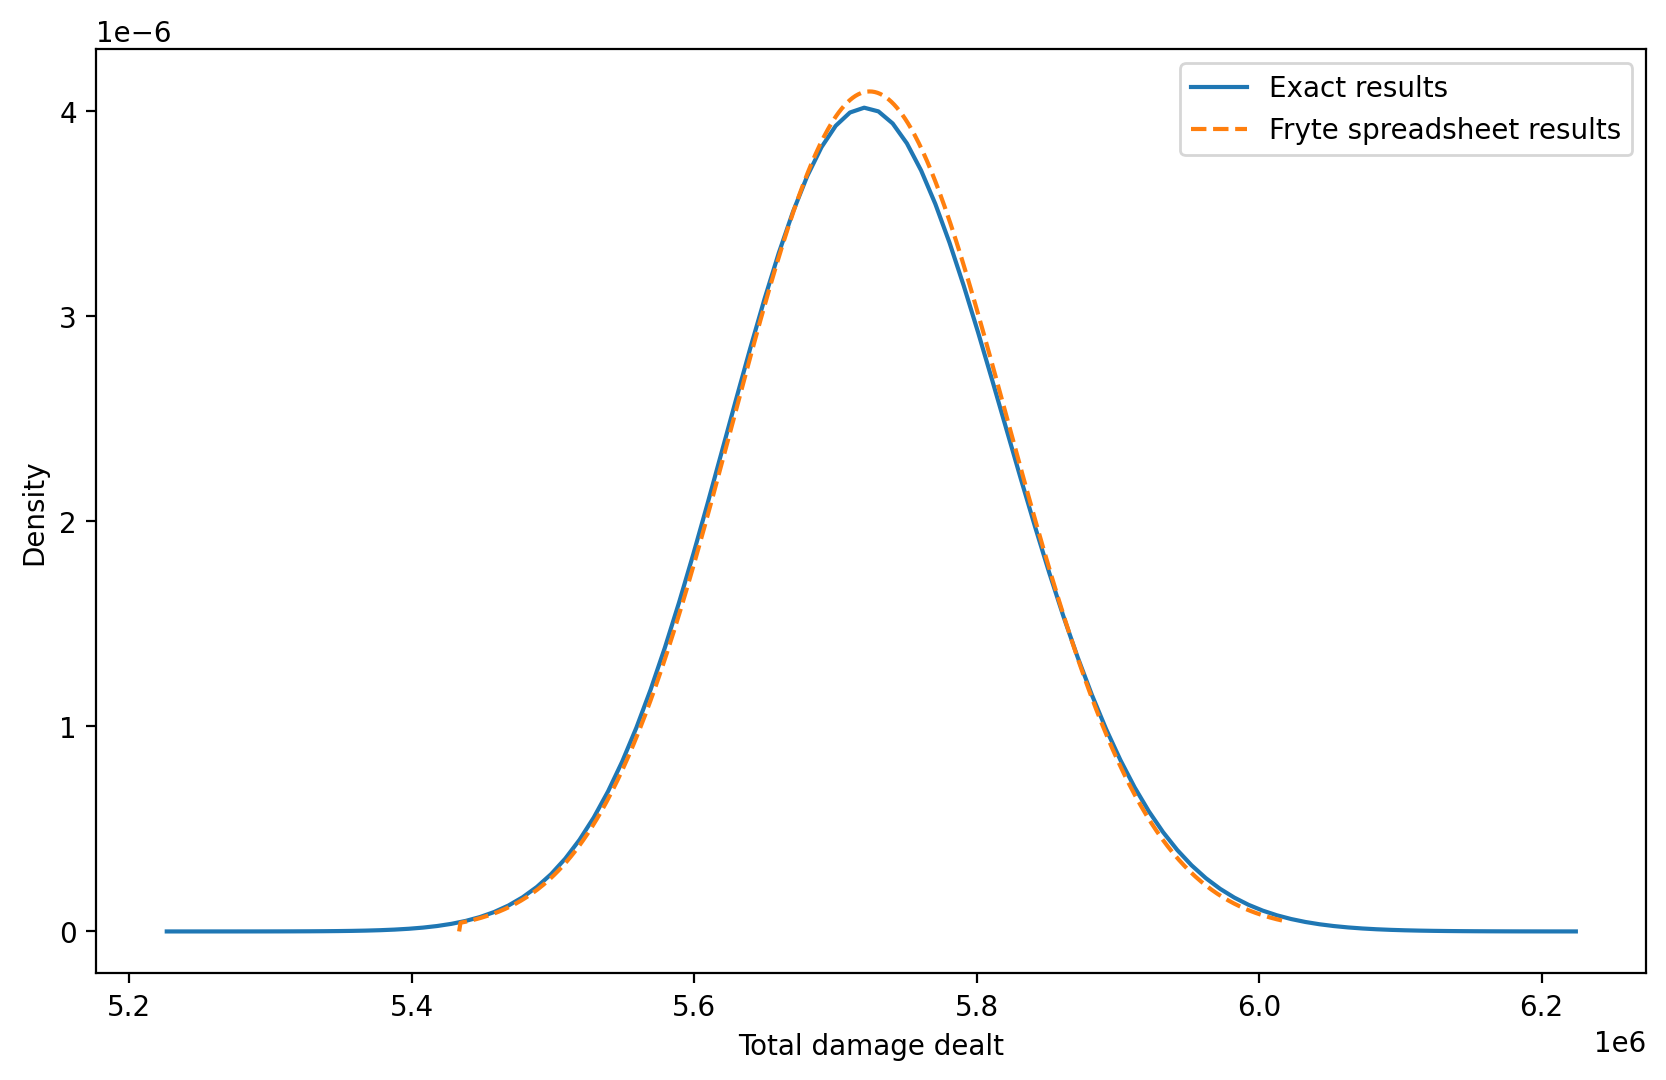

In [228]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10,6), dpi=200)

smn_rotation.plot_rotation_distribution(ax=ax, label='Exact results')
plt.plot(results_comparison['Damage'], results_comparison['Probability'], '--', label='Fryte spreadsheet results')
ax.legend()
ax.set_ylabel('Density')
ax.set_xlabel('Total damage dealt')


## Damage distributions by unique action 

Unique action groups by action name, ignoring buffs. For example, the Astral Impulse sub-distribution contains hits with no buffs, infusion + SL, and SL present.

Not represented super well using matplotlib, but it gives a good enough idea how much each action contributes to the overal DPS distribution, its variance, and how normal it is.

Ideally there'd be something a bit more interactive like plotly.

Text(0.5, 0, 'Total damage dealt')

C:\Users\craig\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\craig\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


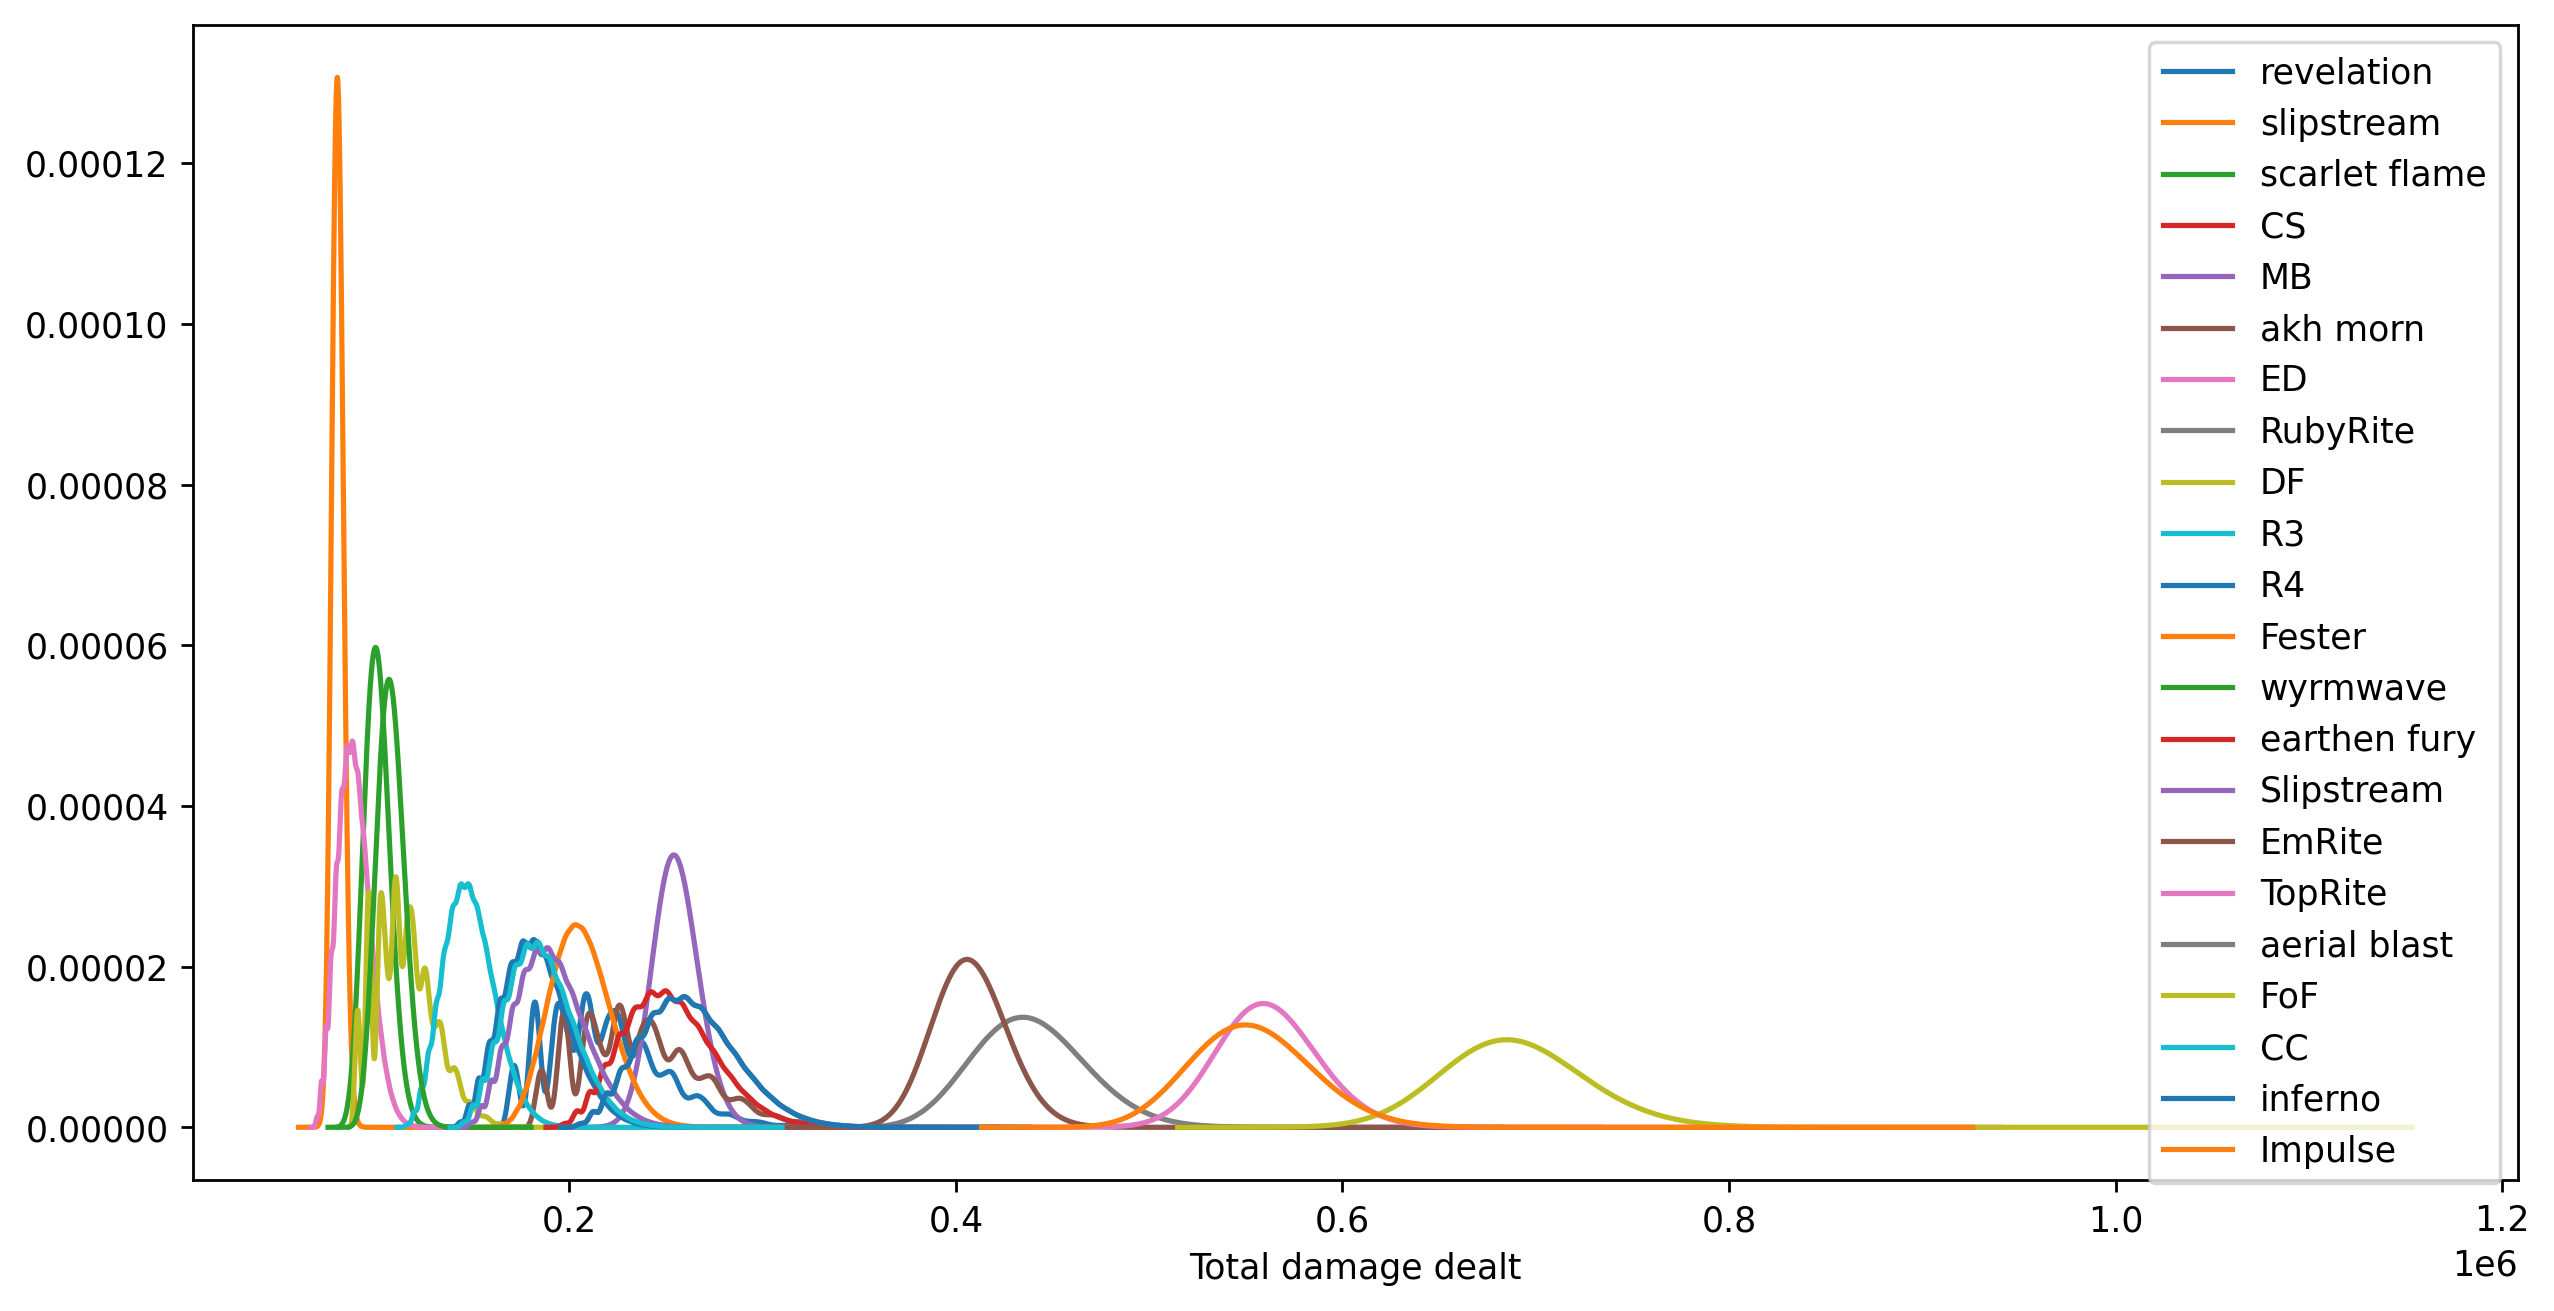

In [229]:
fig, ax = plt.subplots(1, 1, figsize=(12,6), dpi=250)

smn_rotation.plot_unique_action_distributions(ax=ax)
ax.set_xlabel('Total damage dealt')

## Tabular breakdowns

Showing the mean and standard deviation for each unique action.

Functionality isn't (currently) built in, but can be created easily enough by enumerating over unique actions.

In [244]:
summary_df = {
    'Action': [],
    'Mean': [],
    'Standard Dev': []
}

smn_rotation.unique_actions['Impulse']

for action, action_idx in smn_rotation.unique_actions.items():

    means = smn_rotation.action_means[action_idx]
    stds = smn_rotation.action_std[action_idx]

    overall_mean = means.sum() / t_fight
    overall_std = np.sqrt(np.sum(stds**2)) / t_fight
    summary_df['Action'].append(action)
    summary_df['Mean'].append(overall_mean)
    summary_df['Standard Dev'].append(overall_std)

pd.DataFrame(summary_df).sort_values('Mean', ascending=False).round(1)


,Action,Mean,Standard Dev
18,FoF,1449.2,78.1
16,TopRite,1180.8,55.1
21,Impulse,1163.6,65.5
7,RubyRite,922.2,60.9
15,EmRite,856.9,40.0
20,inferno,550.9,51.5
17,aerial blast,550.9,51.5
4,MB,536.7,25.0
13,earthen fury,529.1,49.4
5,akh morn,496.4,65.5
